In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
from sklearn.metrics import silhouette_score
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
import os
import pandas as pd
from glob import glob
#import helper

In [22]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [23]:
def get_MRI_VAE_3D(input_shape=(64,64,64,1), latent_dim=2, batch_size = 32, disentangle=False, gamma=1):
    #TODO: add discriminator loss, see if there is improvement. Perhaps try on shapes dataset if it's easier...

    image_size, _, _, channels = input_shape
    kernel_size = 3
    filters = 16
    intermediate_dim = 128
    epochs = 10

    # VAE model = encoder + decoder
    # build encoder model
    inputs = Input(shape=input_shape, name='encoder_input')
    x = inputs
    for i in range(2):
        filters *= 2
        x = Conv3D(filters=filters,
                   kernel_size=kernel_size,
                   activation='relu',
                   strides=2,
                   padding='same')(x)

    # shape info needed to build decoder model
    shape = K.int_shape(x)

    # generate latent vector Q(z|X)
    x = Flatten()(x)
    x = Dense(intermediate_dim, activation='relu')(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    # instantiate encoder model
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

    # build decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(intermediate_dim, activation='relu')(latent_inputs)
    x = Dense(shape[1] * shape[2] * shape[3] * shape[4], activation='relu')(x)
    x = Reshape((shape[1], shape[2], shape[3],shape[4]))(x)

    for i in range(2):
        x = Conv3DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            activation='relu',
                            strides=2,
                            padding='same')(x)
        filters //= 2

    outputs = Conv3DTranspose(filters=1,
                              kernel_size=kernel_size,
                              activation='sigmoid',
                              padding='same',
                              name='decoder_output')(x)

    # instantiate decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')

    #     decoder.summary()

    # instantiate VAE model
    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name='vae')

    if disentangle:
        discriminator = Dense(1, activation='sigmoid')

        z1 = Lambda(lambda x: x[:int(batch_size/2),:int(latent_dim/2)])(z)
        z2 = Lambda(lambda x: x[int(batch_size/2):,:int(latent_dim/2)])(z)
        s1 = Lambda(lambda x: x[:int(batch_size/2),int(latent_dim/2):])(z)
        s2 = Lambda(lambda x: x[int(batch_size/2):,int(latent_dim/2):])(z)
        q_bar = tf.keras.layers.concatenate(
            [tf.keras.layers.concatenate([s1, z2], axis=1),
            tf.keras.layers.concatenate([s2, z1], axis=1)],
            axis=0)
        q = tf.keras.layers.concatenate(
            [tf.keras.layers.concatenate([s1, z1], axis=1),
            tf.keras.layers.concatenate([s2, z2], axis=1)],
            axis=0)
        q_bar_score = discriminator(q_bar)
        q_score = discriminator(q)        
        tc_loss = K.log(q_score / (1 - q_score)) 

        discriminator_loss = - K.log(q_score) - K.log(1 - q_bar_score)

    reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
    reconstruction_loss *= image_size * image_size
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    if disentangle:
        vae_loss = K.mean(reconstruction_loss) + K.mean(kl_loss) + gamma * K.mean(tc_loss) + K.mean(discriminator_loss)
    else:
        vae_loss = K.mean(reconstruction_loss) + K.mean(kl_loss)

    vae.add_loss(vae_loss)
    vae.compile(optimizer='rmsprop')
    if disentangle:
        vae.metrics_tensors = [reconstruction_loss, kl_loss, tc_loss, discriminator_loss]
    #     vae.summary()
    return encoder, decoder, vae

In [24]:
encoder, decoder, vae = get_MRI_VAE_3D()

In [11]:
data = np.random.rand(3,64,64,64)
vae.train_on_batch(data)

341.4420166015625

In [25]:
data = np.load('../Data/ABIDE-Anat-64iso.npz')['data']

In [26]:
batch_idx = np.random.randint(0,high=data.shape[0],size=16)
data_batch = data[batch_idx,:,:,:]

In [12]:

vae.train_on_batch(data_batch)

10643.2607421875

In [16]:
encoder(data_batch)[0].shape

TensorShape([16, 2])

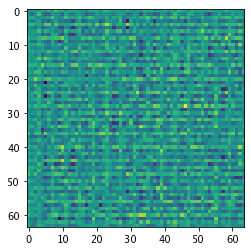

In [30]:
plt.imshow(vae.predict(data_batch)[0,32,:,:,0])

In [36]:
#vae.load_weights?

In [35]:
#vae.load_weights('/Users/aidasaglinskas/Downloads/VAE-initial/variables')

In [20]:
#